In [1]:
import mne
from mne.channels.montage import get_builtin_montages #channel loc
from mne.preprocessing import ICA, create_ecg_epochs
from autoreject import get_rejection_threshold  # noqa
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne.time_frequency import psd_array_multitaper

# https://mne.tools/0.15/auto_tutorials/plot_artifacts_correction_filtering.html

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
import glob
from scipy import signal
from scipy.integrate import simps


In [3]:
# Set channel locations
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
print(ten_twenty_montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>


In [4]:
# Create the info structure needed by MNE
ch_names = ['Fp1','Fpz', 'Fp2', 'AF7']
ch_types = ['eeg','eeg','eeg', 'eeg']
freq = 200
info = mne.create_info(ch_names=ch_names, sfreq=freq, ch_types=ch_types)
mne.Info.set_montage(info, ten_twenty_montage)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AF7
 chs: 4 EEG
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 200.0 Hz
>

In [5]:
data = np.asarray(pd.read_csv('processed\OpenBCI-RAW-2019-06-20_16-06-23_ec.csv', header = None))

In [6]:
# Convert to Volts from microvolts
data = data/10**6

In [7]:
raw = mne.io.RawArray(data, info, first_samp=0, copy='auto', verbose=None)

Creating RawArray with float64 data, n_channels=3, n_times=4831
    Range : 0 ... 4830 =      0.000 ...    24.150 secs
Ready.


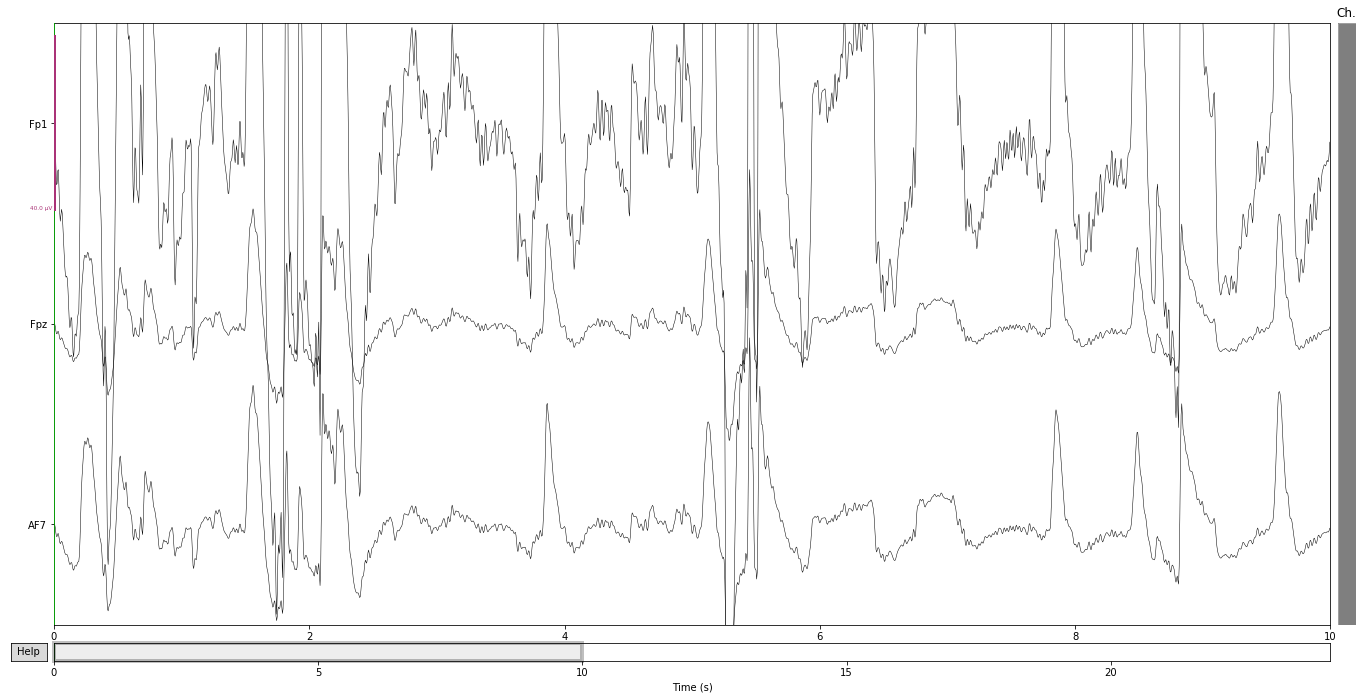

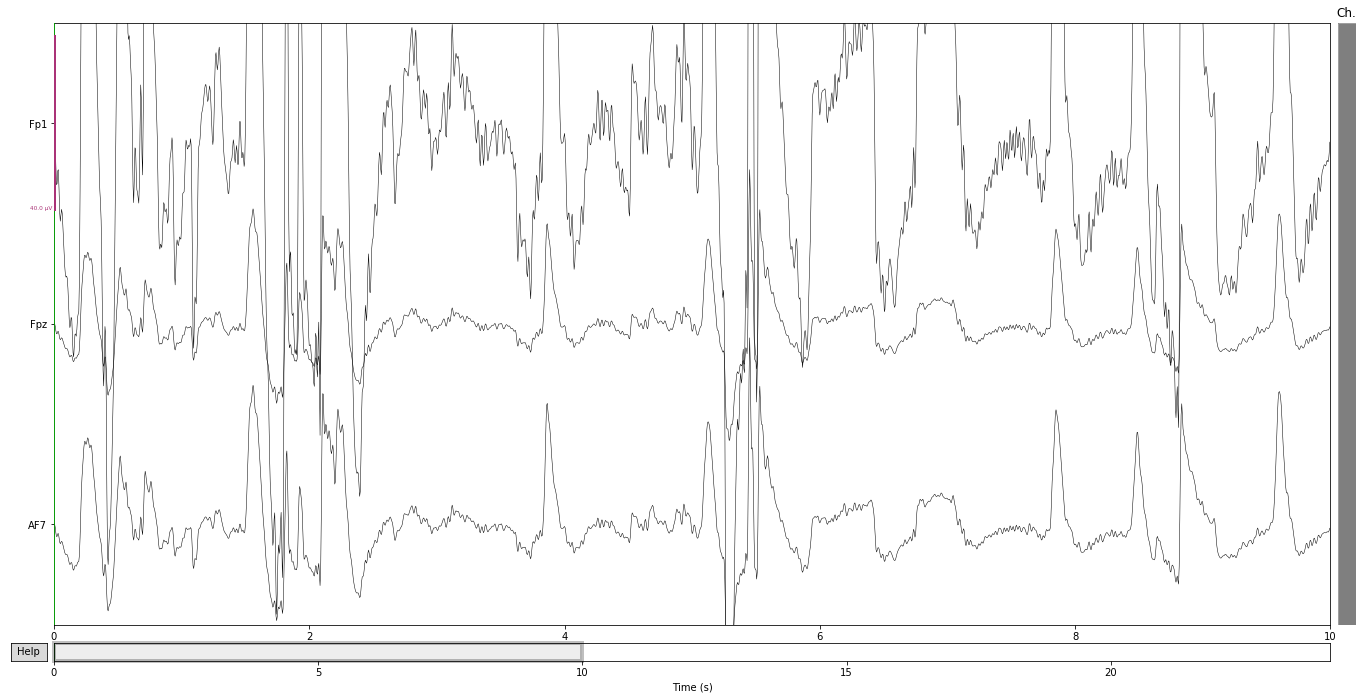

In [8]:
raw.plot()


Creating RawArray with float64 data, n_channels=3, n_times=4831
    Range : 0 ... 4830 =      0.000 ...    24.150 secs
Ready.


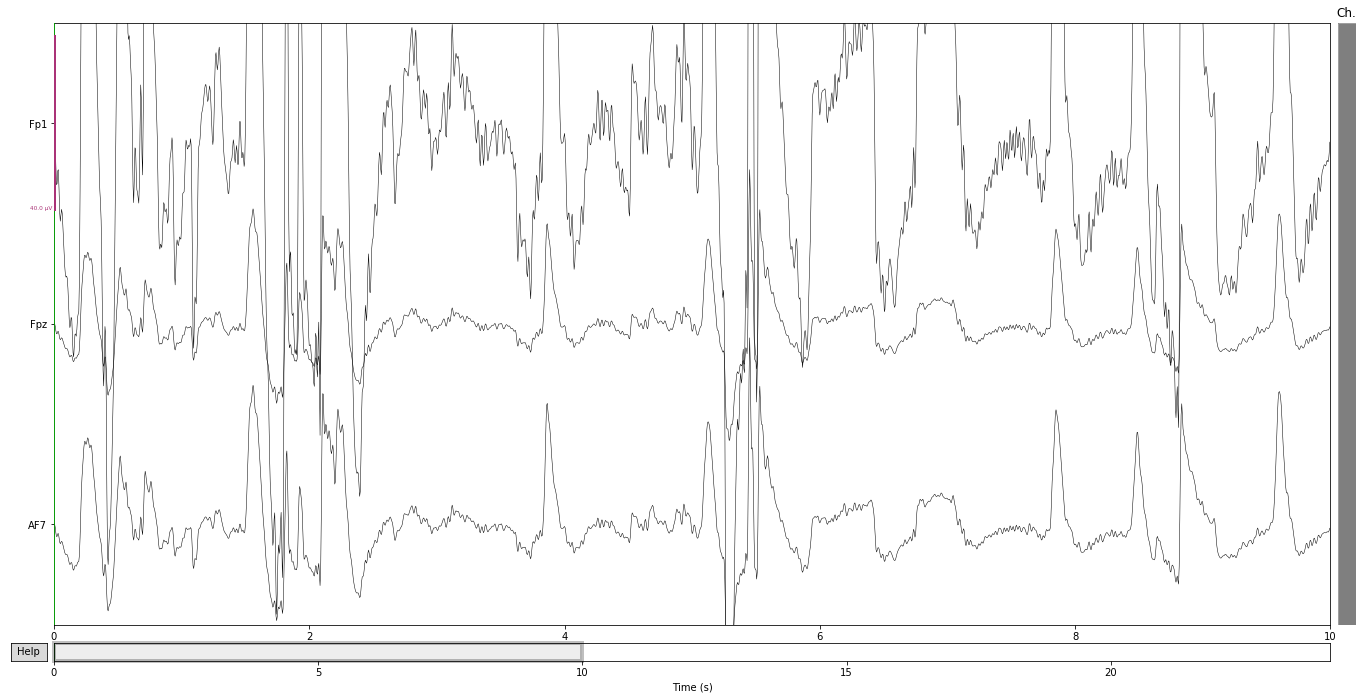

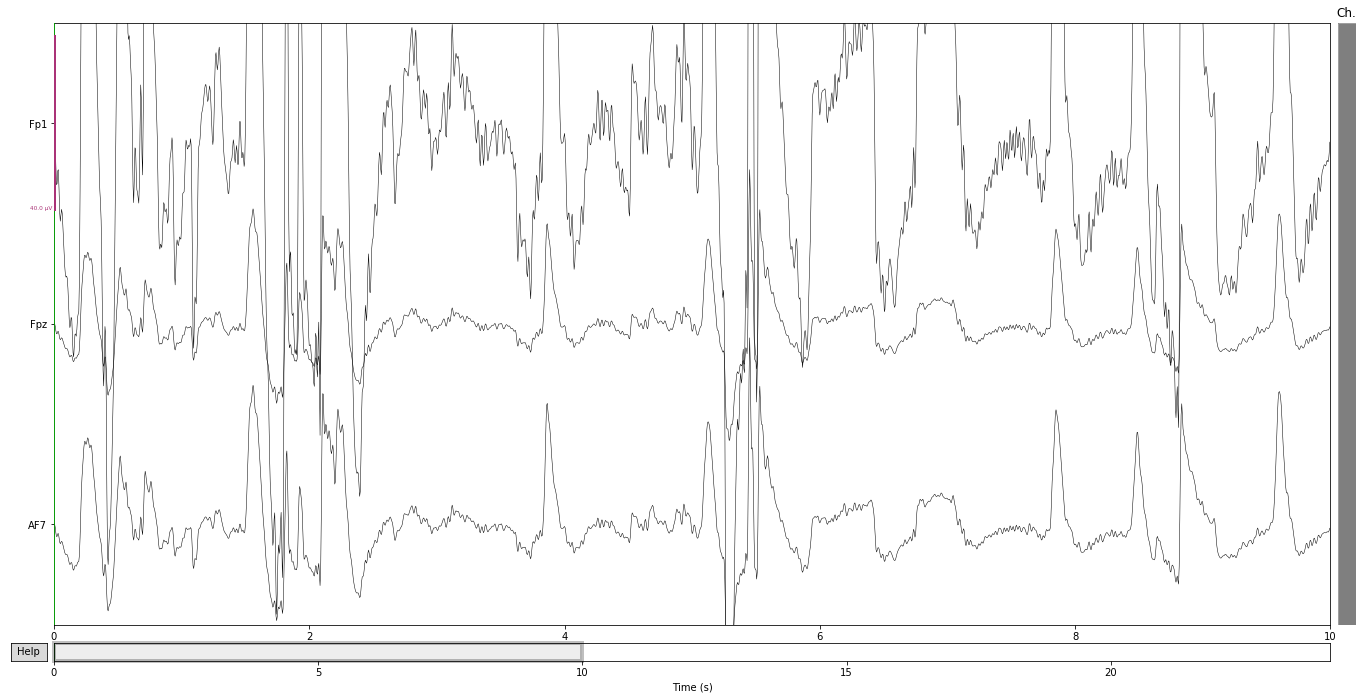

In [9]:
data = np.asarray(pd.read_csv('processed\OpenBCI-RAW-2019-06-20_16-06-23_ec.csv', header = None))
data = data/10**6
raw = mne.io.RawArray(data, info, first_samp=0, copy='auto', verbose=None)
raw.plot()

In [148]:
data

,0,1,2,3
0,0.033068,0.033965,0.027084,0.0
1,6.060290,4.589636,2.575869,0.0
2,1.301190,4.585933,2.751433,0.0
3,5.771748,8.940617,2.483074,0.0
4,5.988682,8.829204,2.361444,0.0
...,...,...,...,...
1919,-24.294641,-18.063747,-4.378036,0.0
1920,-20.012801,-15.184451,-4.518631,0.0
1921,-19.125204,-15.412370,-6.520942,0.0
1922,0.017087,0.981825,3.273537,0.0


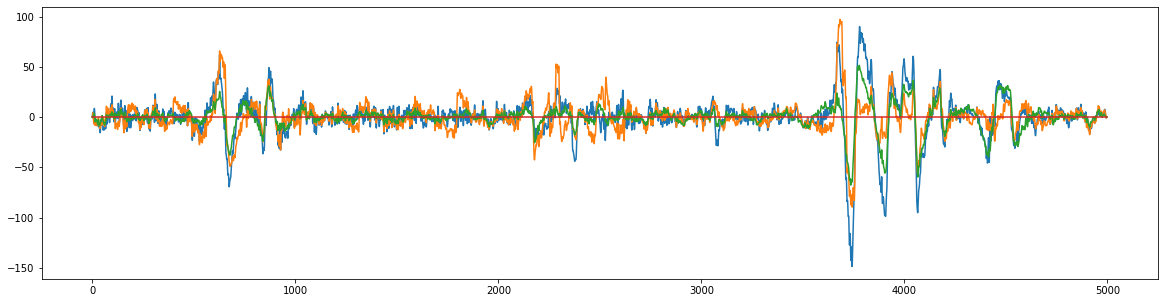

In [165]:
# filtered
data = pd.read_csv('filtered\Green_OpenBCI-RAW-2019-07-23_13-06-04_a23.csv', header = None, sep = '\t')
plt.figure(figsize = (20,5))
plt.plot(data)


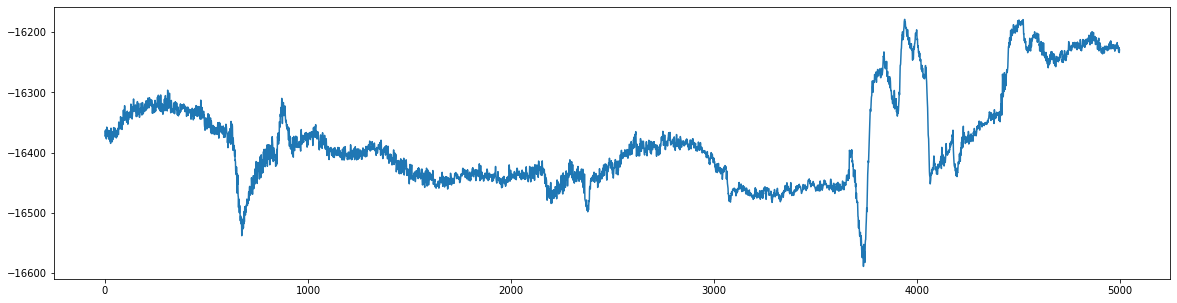

In [166]:
# resamp
data = pd.read_csv('notresamp\Green_OpenBCI-RAW-2019-07-23_13-06-04_a23.csv')
plt.figure(figsize = (20,5))
plt.plot(data['ch1'])

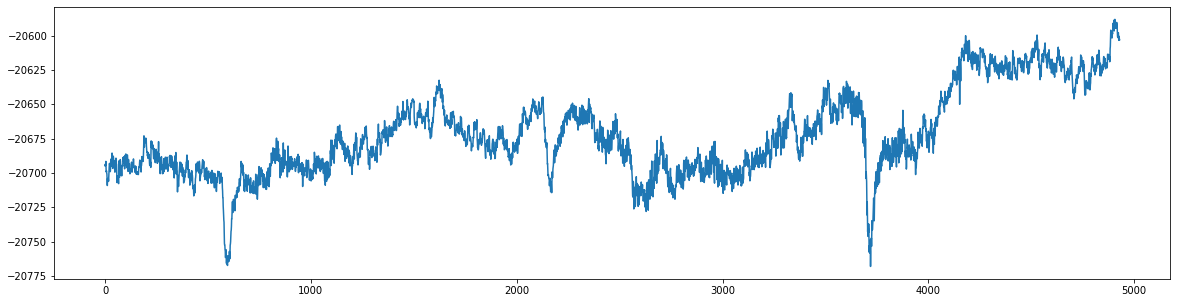

In [157]:
# good_epochs
data = pd.read_csv('good_epochs\OpenBCI-RAW-2019-07-26_14-29-20_b7.csv')
plt.figure(figsize = (20,5))
plt.plot(data['ch1'])

In [9]:
def bandpower(data):
    fmin = [1, 4, 8, 12.5] 
    fmax = [4, 8, 12.5, 30]
    #Delta (1-4 Hz)
    #Theta (4-8 Hz)
    #Alpha (8-12.5 Hz)
    #Beta (12.5-30 Hz)
    ch1_bands = []
    ch2_bands = []
    ch3_bands = []
    ch4_bands = []

    
    # Loop through bands
    for f in range(4):
        #kwargs = dict(fmin=fmin[f], fmax=fmax[f], n_jobs=1)
        psd, freqs = mne.time_frequency.psd_multitaper(data)
 
        # Integral approximation of the spectrum using parabola (Simpson's rule)
        freq_res = freqs[1] - freqs[0]
        
        idx_delta = np.logical_and(freqs >= fmin[f], freqs <= fmax[f])

        ch1_bandpower = simps(psd[0][idx_delta], dx=freq_res)
        ch2_bandpower = simps(psd[1][idx_delta], dx=freq_res)
        ch3_bandpower = simps(psd[2][idx_delta], dx=freq_res)
        ch4_bandpower = simps(psd[3][idx_delta], dx=freq_res)


        ch1_bands.append(ch1_bandpower)
        ch2_bands.append(ch2_bandpower)
        ch3_bands.append(ch3_bandpower)
        ch4_bands.append(ch4_bandpower)
    
    ch1_bands = np.asarray(ch1_bands)
    ch2_bands = np.asarray(ch2_bands)
    ch3_bands = np.asarray(ch3_bands)
    ch4_bands = np.asarray(ch4_bands)

    #Normalize in epoch over bands

    ch1_norm = ch1_bands/sum(ch1_bands)
    ch2_norm = ch2_bands/sum(ch2_bands)
    ch3_norm = ch3_bands/sum(ch3_bands)
    ch4_norm = ch4_bands/sum(ch4_bands)

    # Average over channels
    #avg_bands = (ch1_norm + ch2_norm + ch3_norm)/3
    
    return ch1_bands, ch2_bands, ch3_bands, ch4_bands, ch1_norm, ch2_norm, ch3_norm, ch4_norm

In [21]:
# Loop through all subjects eyes open
i = 0
df_bandpower_norm = pd.DataFrame(columns = ['subject','eyes','Fp1_delta','Fp1_theta', 'Fp1_alpha', 'Fp1_beta',
                                            'Fpz_delta','Fpz_theta', 'Fpz_alpha', 'Fpz_beta',
                                      'Fp2_delta','Fp2_theta', 'Fp2_alpha', 'Fp2_beta',
                                      'AF7_delta','AF7_theta', 'AF7_alpha', 'AF7_beta'])

df_bandpower = pd.DataFrame(columns = ['subject','eyes', 'Fp1_delta','Fp1_theta', 'Fp1_alpha', 'Fp1_beta',
                                       'Fpz_delta','Fpz_theta', 'Fpz_alpha', 'Fpz_beta',
                                      'Fp2_delta','Fp2_theta', 'Fp2_alpha', 'Fp2_beta',
                                      'AF7_delta','AF7_theta', 'AF7_alpha', 'AF7_beta'])

for entry in tqdm(glob.glob('processed/*eo.csv')):
    data = np.asarray(pd.read_csv(entry, header = None))
    trial_data = data[:, 10*freq:-10*freq] # drop 10s padding from start and end

    df_bandpower.loc[i,['subject']] = entry[10:-7]
    df_bandpower_norm.loc[i,['subject']] = entry[10:-7]
    
    df_bandpower.loc[i,['eyes']] = entry[-6:-4]
    df_bandpower_norm.loc[i,['eyes']] = entry[-6:-4]

    
    raw = mne.io.RawArray(trial_data, info,first_samp=0, copy='auto', verbose=None)
    ch1_bands, ch2_bands, ch3_bands, ch4_bands, ch1_norm, ch2_norm, ch3_norm, ch4_norm = bandpower(raw)

    df_bandpower_norm.loc[i,2:6] = ch1_norm
    df_bandpower_norm.loc[i,6:10] = ch2_norm
    df_bandpower_norm.loc[i,10:14] = ch3_norm
    df_bandpower_norm.loc[i,14:] = ch4_norm

    print(ch1_norm)
    
    df_bandpower.loc[i,2:6] = ch1_bands
    df_bandpower.loc[i,6:10] = ch2_bands
    df_bandpower.loc[i,10:14] = ch3_bands
    df_bandpower.loc[i,14:] = ch4_bands

    i += 1

Creating RawArray with float64 data, n_channels=4, n_times=2924
    Range : 0 ... 2923 =      0.000 ...    14.615 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
[0.82123447 0.10155324 0.04627029 0.030942  ]
Creating RawArray with float64 data, n_channels=4, n_times=3027
    Range : 0 ... 3026 =      0.000 ...    15.130 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
[0.35059721 0.25839308 0.14320875 0.24780096]
Creating RawArray with float64 data, n_channels=4, n_times=3054
    Range : 0 ... 3053 =      0.000 ...    15.265 secs
Ready.
    Using multitaper spectrum estimation w

In [23]:
df_bandpower_norm

,subject,eyes,Fp1_delta,Fp1_theta,Fp1_alpha,Fp1_beta,Fpz_delta,Fpz_theta,Fpz_alpha,Fpz_beta,Fp2_delta,Fp2_theta,Fp2_alpha,Fp2_beta,AF7_delta,AF7_theta,AF7_alpha,AF7_beta
0,OpenBCI-RAW-2019-06-20_16-06-23,eo,0.821234,0.101553,0.0462703,0.030942,0.821234,0.101553,0.0462703,0.030942,0.821234,0.101553,0.0462703,0.030942,0.821234,0.101553,0.0462703,0.030942
1,OpenBCI-RAW-2019-06-21_15-48-38,eo,0.350597,0.258393,0.143209,0.247801,0.352356,0.258063,0.143093,0.246489,0.339396,0.256764,0.138994,0.264846,0.351972,0.258136,0.143119,0.246773
2,OpenBCI-RAW-2019-06-24_12-31-44,eo,0.769375,0.128407,0.0561114,0.0461072,0.821376,0.106899,0.0377941,0.0339304,0.832725,0.101924,0.0343725,0.0309783,0.834383,0.101182,0.0339041,0.0305309
3,OpenBCI-RAW-2019-06-25_15-35-22,eo,0.739577,0.172299,0.0428062,0.0453178,0.794865,0.142157,0.0307235,0.0322548,0.795089,0.141676,0.0307884,0.0324466,0.792555,0.144255,0.0309104,0.0322793
4,OpenBCI-RAW-2019-06-26_10-32-20,eo,0.379247,0.162803,0.124418,0.333532,0.379247,0.162803,0.124418,0.333532,0.379247,0.162803,0.124418,0.333532,0.379247,0.162803,0.124418,0.333532
5,OpenBCI-RAW-2019-06-26_12-20-28,eo,0.777114,0.178758,0.0209573,0.0231701,0.747039,0.145941,0.034038,0.0729815,0.786371,0.163677,0.0261131,0.0238391,0.762571,0.138595,0.0326773,0.0661562
6,OpenBCI-RAW-2019-06-27_10-36-31,eo,0.570093,0.215581,0.0690233,0.145303,0.551215,0.266583,0.078902,0.1033,0.552597,0.26773,0.0791289,0.100544,0.579719,0.142622,0.0548455,0.222814
7,OpenBCI-RAW-2019-06-27_11-31-16,eo,0.804355,0.108228,0.0429189,0.0444975,0.767881,0.136138,0.0432589,0.0527218,0.808909,0.126724,0.0340557,0.0303122,0.793322,0.112719,0.0479681,0.0459903
8,OpenBCI-RAW-2019-06-27_12-37-11,eo,0.787237,0.11982,0.0466538,0.0462888,0.746119,0.17387,0.0556043,0.0244063,0.765156,0.1514,0.0597803,0.0236641,0.657673,0.228576,0.0862456,0.0275051
9,OpenBCI-RAW-2019-06-28_10-01-56,eo,0.748265,0.140357,0.0540814,0.057297,0.413421,0.210175,0.104433,0.271971,0.742481,0.135195,0.0585453,0.0637784,0.408404,0.179581,0.123046,0.288969


In [19]:
# Loop through all subjects eyes closed
i = 0
df_bandpower_norm_ec = pd.DataFrame(columns = ['subject','eyes','Fp1_delta','Fp1_theta', 'Fp1_alpha', 'Fp1_beta',
                                            'Fpz_delta','Fpz_theta', 'Fpz_alpha', 'Fpz_beta',
                                      'Fp2_delta','Fp2_theta', 'Fp2_alpha', 'Fp2_beta',
                                      'AF7_delta','AF7_theta', 'AF7_alpha', 'AF7_beta'])

df_bandpower_ec = pd.DataFrame(columns = ['subject','eyes', 'Fp1_delta','Fp1_theta', 'Fp1_alpha', 'Fp1_beta',
                                       'Fpz_delta','Fpz_theta', 'Fpz_alpha', 'Fpz_beta',
                                      'Fp2_delta','Fp2_theta', 'Fp2_alpha', 'Fp2_beta',
                                      'AF7_delta','AF7_theta', 'AF7_alpha', 'AF7_beta'])

for entry in tqdm(glob.glob('processed/*ec.csv')):
    data = np.asarray(pd.read_csv(entry, header = None))
    trial_data = data[:, 10*freq:-10*freq] # drop 10s padding from start and end

    df_bandpower_ec.loc[i,['subject']] = entry[10:-7]
    df_bandpower_norm_ec.loc[i,['subject']] = entry[10:-7]
    
    df_bandpower_ec.loc[i,['eyes']] = entry[-6:-4]
    df_bandpower_norm_ec.loc[i,['eyes']] = entry[-6:-4]

    
    raw = mne.io.RawArray(trial_data, info,first_samp=0, copy='auto', verbose=None)
    ch1_bands, ch2_bands, ch3_bands, ch4_bands, ch1_norm, ch2_norm, ch3_norm, ch4_norm = bandpower(raw)

    df_bandpower_norm_ec.loc[i,2:6] = ch1_norm
    df_bandpower_norm_ec.loc[i,6:10] = ch2_norm
    df_bandpower_norm_ec.loc[i,10:14] = ch3_norm
    df_bandpower_norm_ec.loc[i,14:] = ch4_norm

    print(ch1_norm)
    
    df_bandpower_ec.loc[i,2:6] = ch1_bands
    df_bandpower_ec.loc[i,6:10] = ch2_bands
    df_bandpower_ec.loc[i,10:14] = ch3_bands
    df_bandpower_ec.loc[i,14:] = ch4_bands

    i += 1

Creating RawArray with float64 data, n_channels=4, n_times=3035
    Range : 0 ... 3034 =      0.000 ...    15.170 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
[0.70014555 0.1575296  0.06260724 0.0797176 ]
Creating RawArray with float64 data, n_channels=4, n_times=3039
    Range : 0 ... 3038 =      0.000 ...    15.190 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
[0.36134837 0.26385861 0.13692428 0.23786873]
Creating RawArray with float64 data, n_channels=4, n_times=3037
    Range : 0 ... 3036 =      0.000 ...    15.180 secs
Ready.
    Using multitaper spectrum estimation w

In [20]:
df_bandpower_norm_ec

,subject,eyes,Fp1_delta,Fp1_theta,Fp1_alpha,Fp1_beta,Fpz_delta,Fpz_theta,Fpz_alpha,Fpz_beta,Fp2_delta,Fp2_theta,Fp2_alpha,Fp2_beta,AF7_delta,AF7_theta,AF7_alpha,AF7_beta
0,OpenBCI-RAW-2019-06-20_16-06-23,ec,0.700146,0.15753,0.0626072,0.0797176,0.700146,0.15753,0.0626072,0.0797176,0.700146,0.15753,0.0626073,0.0797176,0.700146,0.15753,0.0626072,0.0797176
1,OpenBCI-RAW-2019-06-21_15-48-38,ec,0.361348,0.263859,0.136924,0.237869,0.373981,0.265493,0.1316,0.228926,0.366409,0.267006,0.130742,0.235843,0.378139,0.262808,0.132212,0.226841
2,OpenBCI-RAW-2019-06-24_12-31-44,ec,0.698907,0.171338,0.0637799,0.065975,0.734091,0.158379,0.0531011,0.054428,0.735094,0.161528,0.0524139,0.0509635,0.736505,0.156389,0.0527159,0.0543903
3,OpenBCI-RAW-2019-06-25_15-35-22,ec,0.726868,0.17759,0.0548129,0.0407293,0.833852,0.114397,0.0311536,0.020597,0.829703,0.116851,0.0319642,0.0214822,0.815525,0.127741,0.034027,0.0227067
4,OpenBCI-RAW-2019-06-26_10-32-20,ec,0.643189,0.152273,0.0836926,0.120845,0.645121,0.152014,0.0834202,0.119445,0.562108,0.154192,0.0954956,0.188204,0.29883,0.182381,0.132911,0.385877
5,OpenBCI-RAW-2019-06-26_12-20-28,ec,0.425746,0.171366,0.146609,0.256279,0.43946,0.173202,0.148338,0.239,0.389225,0.165477,0.161539,0.283759,0.42039,0.170556,0.147752,0.261302
6,OpenBCI-RAW-2019-06-27_10-36-31,ec,0.855995,0.080194,0.0438167,0.0199946,0.764045,0.134214,0.0612711,0.0404705,0.871353,0.0738401,0.0365628,0.0182445,0.860318,0.0754383,0.0416943,0.0225498
7,OpenBCI-RAW-2019-06-27_11-31-16,ec,0.522036,0.239148,0.140979,0.0978367,0.568151,0.195641,0.100381,0.135827,0.537003,0.219766,0.140111,0.10312,0.559622,0.206846,0.100502,0.13303
8,OpenBCI-RAW-2019-06-27_12-37-11,ec,0.490362,0.194379,0.100943,0.214316,0.5021,0.136931,0.140547,0.220422,0.717339,0.12881,0.0602468,0.0936045,0.507175,0.0774354,0.125651,0.289738
9,OpenBCI-RAW-2019-06-28_10-01-56,ec,0.215733,0.313623,0.191607,0.279037,0.215691,0.313865,0.191751,0.278693,0.240029,0.279626,0.175855,0.30449,0.459958,0.162941,0.104464,0.272637


In [16]:
df_bandpower_norm.to_csv('pkcogwear_bandpowers.csv')

In [27]:
import seaborn as sns


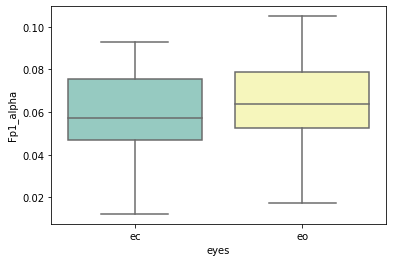

In [43]:
sns.boxplot(x="eyes", y="Fp1_alpha", data=df_bandpower_norm, palette="Set3", showfliers = False)


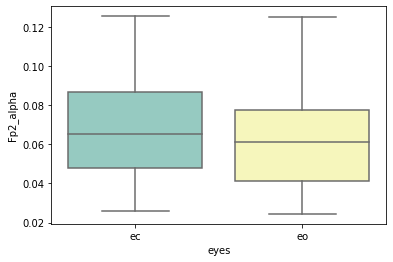

In [54]:
sns.boxplot(x="eyes", y="Fp2_alpha", data=df_bandpower_norm, palette="Set3", showfliers = False)


In [28]:
from scipy.stats import ttest_rel


In [29]:
eo = df_bandpower_norm.drop([12])
ec = df_bandpower_norm_ec

In [31]:
len(eo), len(ec)

(18, 18)

In [63]:
np.log(eo["Fp1_alpha"].astype('float'))

1     10.504420
3      5.848082
5     16.777676
7     14.153001
9      5.302624
11     6.858710
13     7.253200
15     7.488031
17     7.923835
19    17.577313
21     7.001932
23     8.992790
25     5.223228
28    13.496804
30    12.195051
32    12.369418
34    14.032115
36    14.712409
38    15.358648
Name: Fp1_alpha, dtype: float64

In [32]:
ttest_rel(np.log(eo["Fp1_alpha"].astype('float')) - np.log(eo["Fp2_alpha"].astype('float')),
          np.log(ec["Fp1_alpha"].astype('float')) - np.log(ec["Fp2_alpha"].astype('float')))

Ttest_relResult(statistic=0.3051698957852032, pvalue=0.7639415292790345)

In [41]:
# Theta
print(ttest_rel(eo["Fp1_theta"], ec["Fp1_theta"]))
print(ttest_rel(eo["Fpz_theta"], ec["Fpz_theta"]))
print(ttest_rel(eo["Fp2_theta"], ec["Fp2_theta"]))
print(ttest_rel(eo["AF7_theta"], ec["AF7_theta"]))

Ttest_relResult(statistic=-1.1991242802100035, pvalue=0.24692740881622635)
Ttest_relResult(statistic=-0.3923792740356816, pvalue=0.6996539136733313)
Ttest_relResult(statistic=-0.30306762363993944, pvalue=0.765515652030388)
Ttest_relResult(statistic=0.22130550888964085, pvalue=0.8274909461068958)


In [39]:
# Delta
print(ttest_rel(eo["Fp1_delta"], ec["Fp1_delta"]))
print(ttest_rel(eo["Fpz_delta"], ec["Fpz_delta"]))
print(ttest_rel(eo["Fp2_delta"], ec["Fp2_delta"]))
print(ttest_rel(eo["AF7_delta"], ec["AF7_delta"]))

Ttest_relResult(statistic=1.8657976262892086, pvalue=0.07942136131225064)
Ttest_relResult(statistic=1.8375222445825012, pvalue=0.08367616859640595)
Ttest_relResult(statistic=1.8792596856325998, pvalue=0.07746378848405783)
Ttest_relResult(statistic=1.6669830773066128, pvalue=0.11383326412808162)


In [47]:
# alpha
print(ttest_rel(eo["Fp1_alpha"], ec["Fp1_alpha"]))
print(ttest_rel(eo["Fpz_alpha"], ec["Fpz_alpha"]))
print(ttest_rel(eo["Fp2_alpha"], ec["Fp2_alpha"]))
print(ttest_rel(eo["AF7_alpha"], ec["AF7_alpha"]))

Ttest_relResult(statistic=-2.0270313769280093, pvalue=0.05863804320282778)
Ttest_relResult(statistic=-2.7863094459242004, pvalue=0.012664896082292581)
Ttest_relResult(statistic=-2.478004203341528, pvalue=0.024003153274905938)
Ttest_relResult(statistic=-1.8159631753899605, pvalue=0.08705420604561456)


In [42]:
# Beta
print(ttest_rel(eo["Fp1_beta"], ec["Fp1_beta"]))
print(ttest_rel(eo["Fpz_beta"], ec["Fpz_beta"]))
print(ttest_rel(eo["Fp2_beta"], ec["Fp2_beta"]))
print(ttest_rel(eo["AF7_beta"], ec["AF7_beta"]))


Ttest_relResult(statistic=-1.2506406191626889, pvalue=0.22800594966080642)
Ttest_relResult(statistic=-1.3699623489999138, pvalue=0.18852203450829064)
Ttest_relResult(statistic=-1.8078999101935438, pvalue=0.08834811112769866)
Ttest_relResult(statistic=-1.4230398969079838, pvalue=0.17281724691636263)


{'whiskers': [<matplotlib.lines.Line2D at 0x2b32b4e2d88>,
 'caps': [<matplotlib.lines.Line2D at 0x2b32b98b808>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b32b4e2b48>,
 'medians': [<matplotlib.lines.Line2D at 0x2b32b96dac8>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b32b96dd48>,
 'means': []}

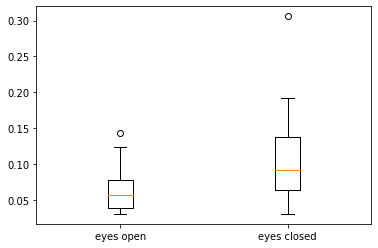

In [50]:
plt.boxplot([eo["Fpz_alpha"], ec["Fpz_alpha"]], labels = ['eyes open', 'eyes closed'], ylabel)